#Problème: Cible fragmentaire et fusion de donnée



Dans ce problème, il s'agit de reconstruire un champ spatialisé cible à partir d'un prédicteur spatialisé et d'observations ponctuelles.  
Dans la première partie, on adapte simplement la procédure de régression pixel à pixel standard au cas où les données cibles ne sont renseignées qu'en quelques pixels.\
Dans la seconde partie, on entraîne un réseau à prendre les deux types de données (champ spatialisé et données ponctuelles) en entrée pour reconstruire au mieux la cible complète.


In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! ls .

correction_BE_exercice_reid.ipynb	  session2_exercice1.ipynb
enonce_BE_exercice_reid_correction.ipynb  session2_exercice2.ipynb
__pycache__				  utile_BE_session2.py


In [ ]:
os.chdir('drive/MyDrive/...')

In [ ]:
from utile_BE_session2 import *

###Partie I: donnée cible fragmentaire


Dans cette partie, le lien entre le champ spatialisé et le champ cible est déterministe. L'exercice consiste à adapter la procédure d'apprentissage au cas où les données ne sont renseignées qu'en quelques pixels (cible "fragmentaire").\
La fonction *gen_ponct* permet de génerer des données d'apprentissage de synthèse. Le paramètre *p* représente la proportion de pixels pour lesquels
la mesure cible est diponible. Dans cette partie, nous la fixons à 0.002:

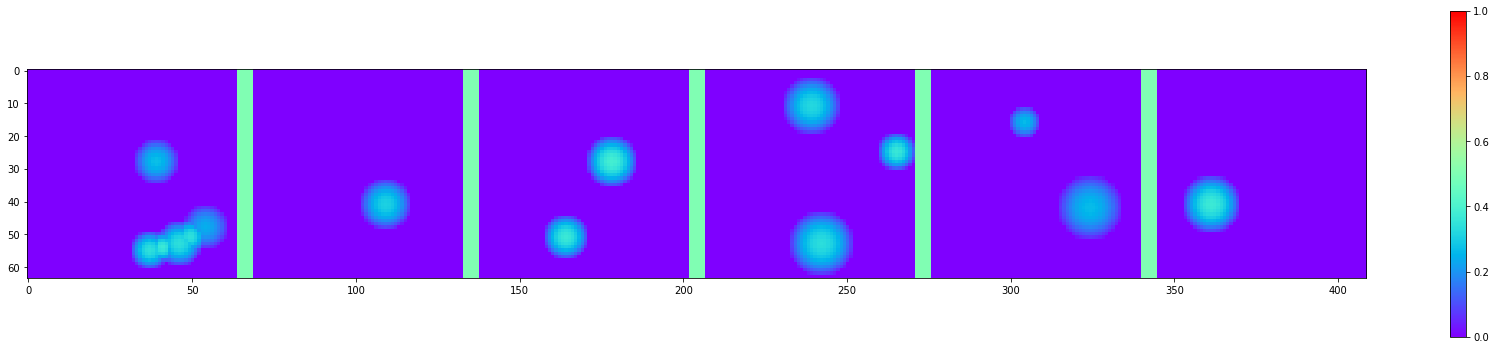

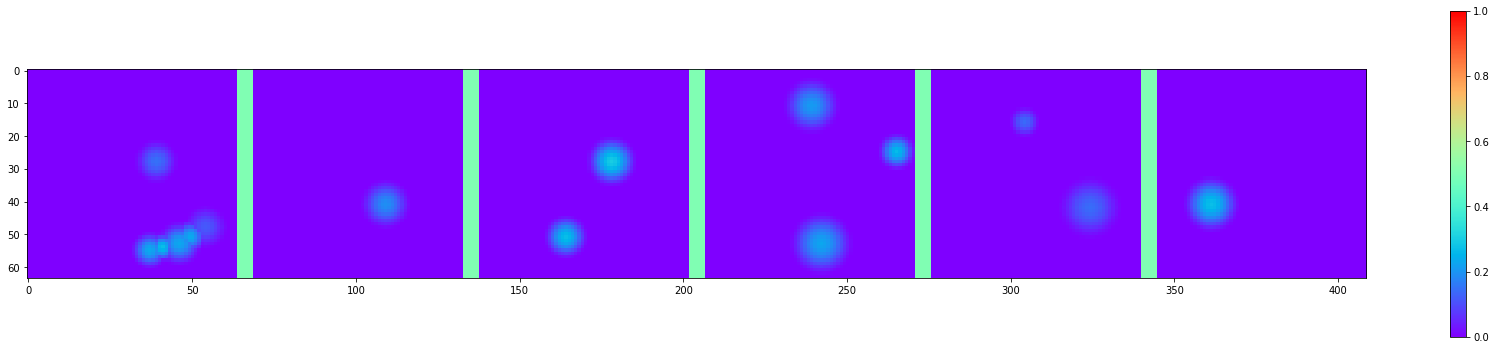

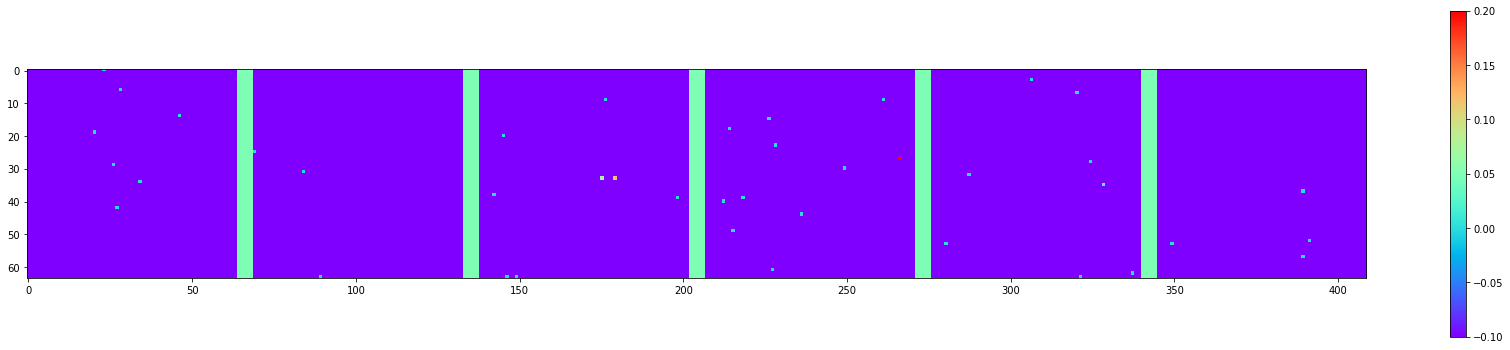

In [ ]:
input,  target, fulltarget  = gen_ponct(6,p=0.002)  

# input: prédicteur spatialisé 
fig0 = plt.figure(0, figsize=(30, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)  

# fulltarget: cible complète, qu'on ne peut pas utiliser pour l'apprentissage
fig1 = plt.figure(1, figsize=(30, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)  #deuxième ligne: cibles complètes

# target: cible fragmentaire: diponible pour l'apprentissage
fig2 = plt.figure(2, figsize=(30, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2)   #troisième cible: observations ponctuelles fragmentaires

**Q1** Coder la fonction de coût masked_MAE,
       qui limite le calcul de la MAE (Mean Absolute Error)
       aux pixels pour lesquels une observation est disponible.


In [ ]:
def masked_MAE(output, target, mask):

  ...

  return loss

**Q2** Est-il nécessaire d'implémenter une étape de validation ici ? Pourquoi ?

**Q3** Entraîner un UNet avec cette fonction de coût. Visualiser la courbe d'apprentissage. 

In [ ]:
fcn = UNet(1,1,8) 
import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [ ]:
nepochs = 20
nbatches = 100
batchsize = 64
train_losses = []


for epoch in range(nepochs):
    print("Epoch " + str(epoch))
    epoch_losses  = []   
    for i in range(nbatches):    # nbatch = datasetsize/batchsize
        #inputs
        input, target, _ = gen_ponct(batchsize,p = 0.002)


        ...

**Q4** Visualiser les résultats au bout de 20 - 30 époques. Commenter.

**Q5** Quel est l'impact du caractère fragmentaire de la cible ? Justifier un minimum.

**Partie II**\
Dans cette partie, le prédicteur n'est plus suffisant pour estimer la cible complète.\
Précisément, certaines cellules sont associées un signal cible de forte intensité (cellules de type 1), les autres sont associées à un signal de faible intensité (cellules de type 2).
Visualisons-les:


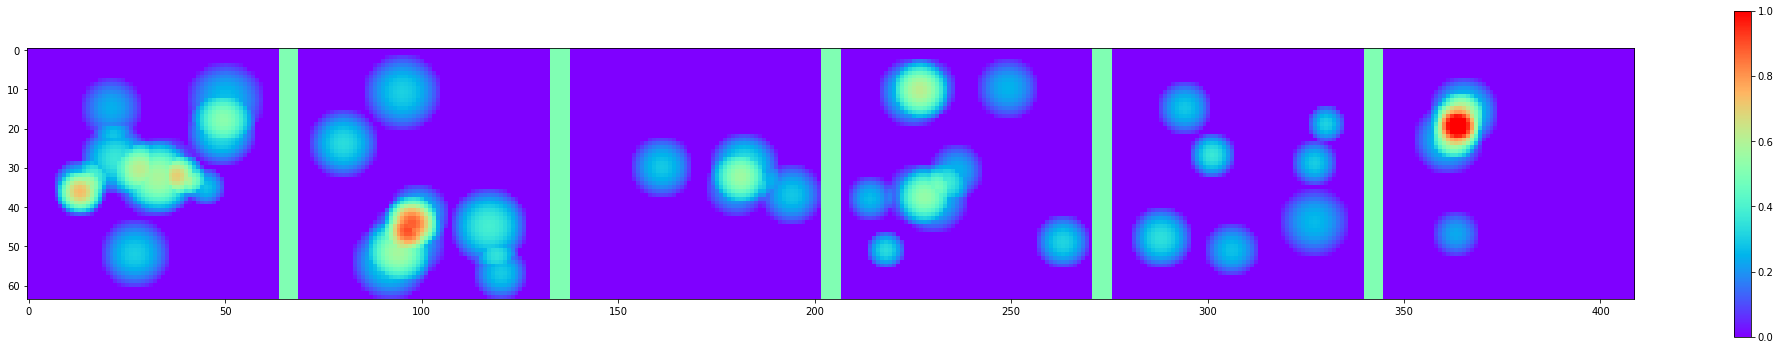

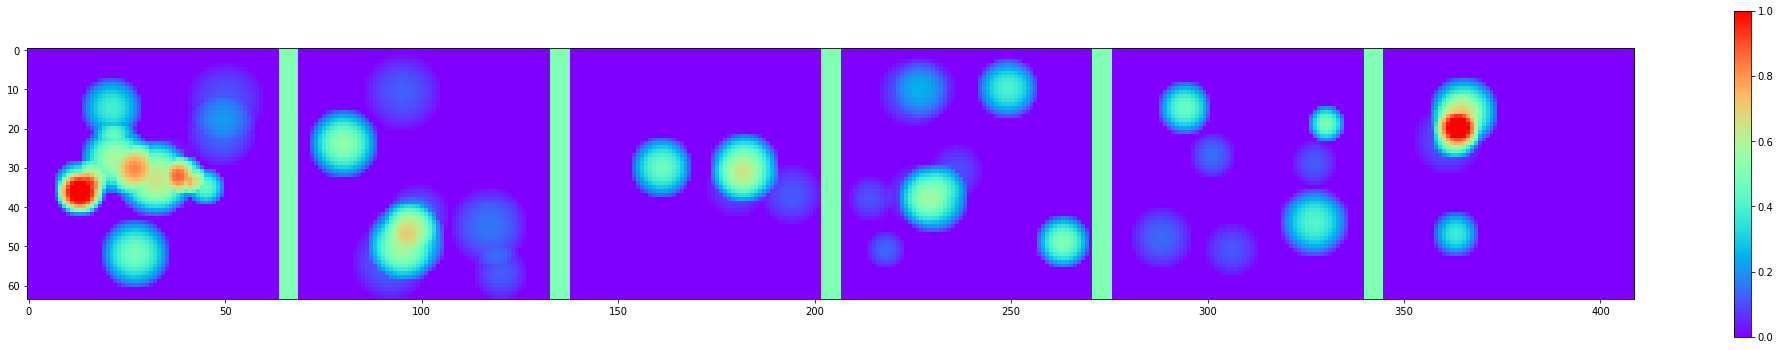

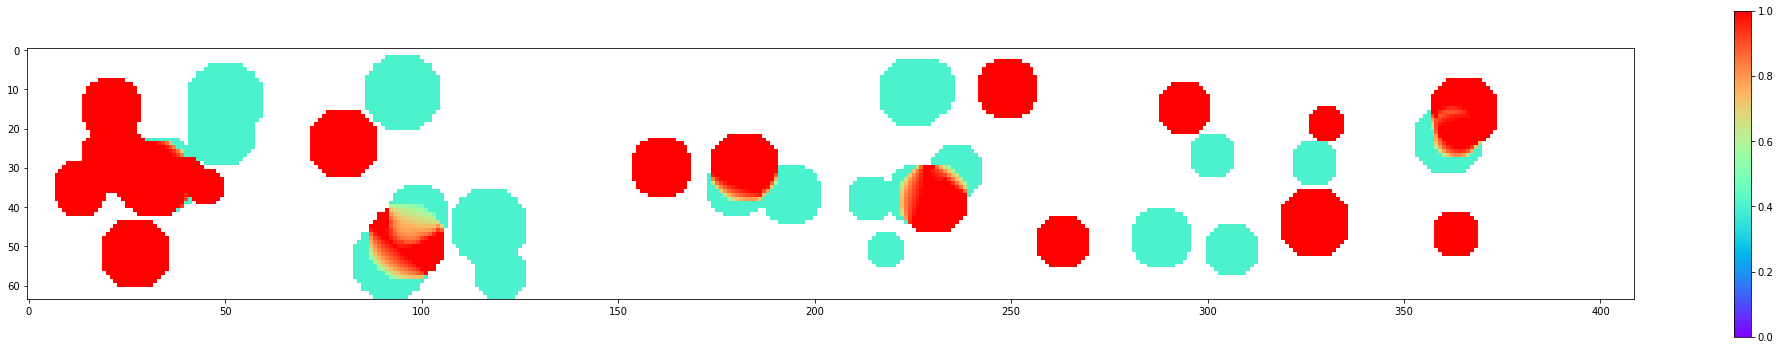

In [ ]:
input,  target, fulltarget  = gen_mixt(6,0.002) 

# le signal d'entrée, spatialisé
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# le signal cible complet où les deux types de cellules apparaissent 
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D(fulltarget, 6, fig1, k=0, min_scale=0,max_scale=1)

# le rapport entre les deux
fig1 = plt.figure(1, figsize=(36, 6))
voir_batch2D((fulltarget/input)*(fulltarget>0), 6, fig1, k=0, min_scale=0,max_scale=1)

Dans la troisième ligne (cible complète), on observe les deux types de cellules.
Les cellules de type 1 ont une intensité de 60% plus élevée que la cellule du prédicteur tandis que les cellules de type 2 on une intensité de 60% plus faible.\
Noter qu'il n'y a aucune information dans le prédicteur qui permette de savoir à quel type de cellule on a affaire.

La cible fragmentaire ne comporte, là encore, que 0.2 % des valeurs du champ cible. Mais ces quelques valeurs contiennent, elles, une information sur le type de cellule:

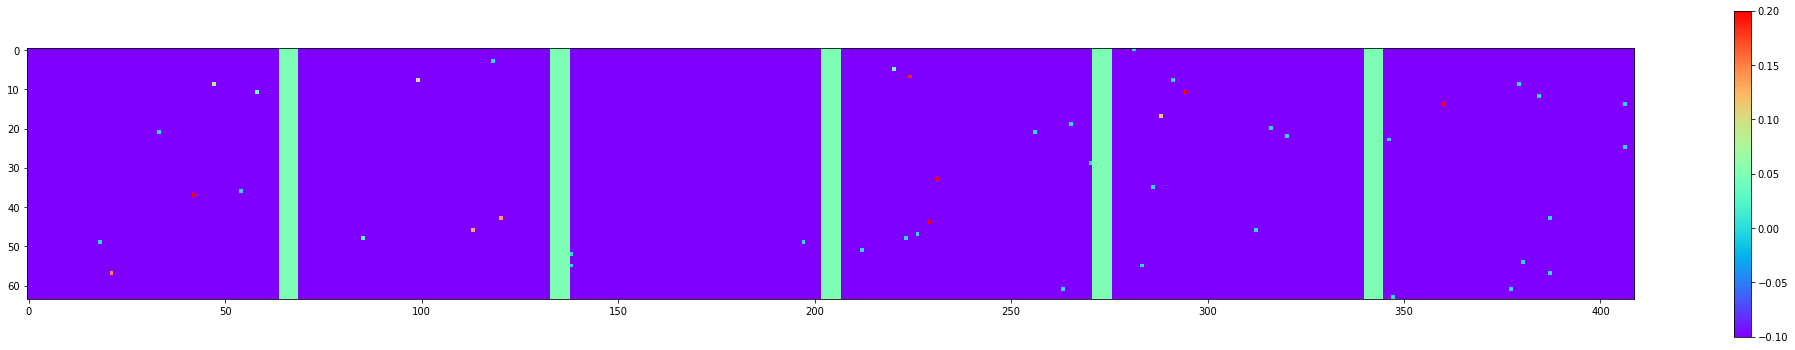

In [ ]:
#la cible fragmentaire:
fig2 = plt.figure(2, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=-0.1,max_scale=0.2) 

**Q1** Entraîner un UNet sur la cible fragmentaire **en n'utilisant que le prédicteur en entrée**.\
Choisir la fonction de coût de manière à estimer la moyenne conditionnelle à l'entrée.\
Visualiser le résultat et en déduire (sans calcul) la fréquence de chacun des types de cellule.

On se place maintenant dans le cas où les observations ponctuelles (cible fragmentaire) sont aussi disponibles comme prédicteur.

**Q2** Modifier la procédure d'entraînement précédente de façon à ce que le réseau puisse tenir compte des mesures ponctuelles disponibles. 

**Q3** Entraîner ce réseau et commenter à partir d'une sortie. Dans quelle mesure le réseau parvient-il à lever l'ambiguité sur le type de cellule en présence ?

**Q4** Pour prédire la valeur d'un pixel, un FCN permet de prendre en compte le contexte, c'est à dire l'information contenue dans un large voisinage autour du pixel d'intérêt.\
Cette qualité était-elle nécessaire pour traiter la **partie I** du problème ? Etait-elle nécessaire pour traiter la **partie II** ? Justifier.